In [1]:
# Plotting script for results
import os
import matplotlib.pyplot as plt
from utils.read_results_helpers import read_component_results, get_result, calculate_mean_cost_comp_list, get_demand, read_objective_value
from utils.plotting_helpers import get_hatching_color, set_title, set_x_y_labels, get_colors

In [2]:
total_hours = 8784
# Plotting results for cost and capacity
def plot_results(results_dir, color_dict, poi, technologies, outfile_suffix = '', pass_results=[], rm_plot=True):
    all_results = []
    max_result = 0

    fig, ax = plt.subplots()

    files = [f for f in os.listdir(results_dir) if f.endswith('.pickle')]

    if rm_plot == True:
        files.pop(files.index('all_firm_all.pickle'))
        files_sorted = sorted(files, key=lambda x: int(x.split('_')[2]))
        files_sorted = list(files_sorted)
        files_sorted.insert(0, 'all_firm_all.pickle')
    else:
        files_sorted = sorted(files, key=lambda x: float(x.split('_')[2].replace('.pickle', '').replace('p', '.')))

    sorted_components, sorted_technologies = calculate_mean_cost_comp_list(results_dir, files_sorted, technologies, total_hours, poi)


    # Loop over all case pickle files in all_firm_case folder
    for i,case_file in enumerate(files_sorted):

        if pass_results == []:
            # Load results
            component_results = read_component_results(results_dir, case_file)
            # Calculate results
            results = get_result(component_results, total_hours, poi)
            # Sort results by value in descending order
            results = {k: v for k, v in sorted(results.items(), key=lambda item: item[1], reverse=True)}
            all_results.append(results)
        else:
            results = pass_results[1][i]
        

        if i==0 or len([x for x in results.values() if x != 0]) > 0:
        
  
            # Stacked bar plot of results
            bottom_value = 0
            if case_file != files_sorted[-1]:
                x_tick_label = files_sorted[i+1].replace('all_firm', '').replace('.pickle', '').replace('_{0}_'.format(i), '')
                if "CO2" in x_tick_label:
                    x_tick_label = "direct air capture"
            else:
                if "no_generators" in outfile_suffix:
                    x_tick_label = "no storage left"
                else:
                    x_tick_label = "only solar and wind"
            x_tick_label = x_tick_label.replace('_', ' ')

            for component in sorted_components:

                if "no_generators" in outfile_suffix and (component == 'CO2 storage tank' or component == 'direct air capture'):
                    continue
                if not case_file == 'all_firm_all.pickle':
                    if component not in results or results[component] == 0:
                        continue

                hatched, fill_color, hatch_color = get_hatching_color(component, sorted_technologies, color_dict)

                ax.bar(x_tick_label, results[component], width=0.25, color=fill_color, hatch=hatched,
                edgecolor=hatch_color, bottom=bottom_value, label=component)

                bottom_value += results[component]

            # Get max result
            if sum(results.values()) > max_result:
                max_result = sum(results.values())
            
            # Get legend handles and labels for all_firm_all case
            if case_file == 'all_firm_all.pickle':
                handles, labels = ax.get_legend_handles_labels()
                # labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0].lower()))
                labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: sorted_components.index(t[0])))

    # Plot labels
    ax = set_x_y_labels(outfile_suffix, poi, ax)

    # Set title
    ax = set_title(outfile_suffix, ax)


    ax.set_ylim(0, 1.2*max_result)
  
    # Order the legend entries into the columns
    if "no_generators" in outfile_suffix:
        technologies['demand_handling'] = [x for x in technologies['demand_handling'] if x != 'CO2 storage tank' and x != 'direct air capture']
    # Order the legend entries the same as technologies
    # labels = technologies['generators'] + technologies['storage_unconstrained'] + technologies['storage_constrained'] + technologies['demand_handling']
    # handles = [handles[labels.index(label)] for label in labels]
    ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(0., -0.42, 0.41, 0.), ncol=3, fontsize=7)

    # Save plot
    plt.savefig(results_dir+'/total_{0}{1}.png'.format(poi, outfile_suffix), dpi=fig.dpi, bbox_inches='tight')
    plt.savefig(results_dir+'/total_{0}{1}.pdf'.format(poi, outfile_suffix), dpi=fig.dpi, bbox_inches='tight')
    plt.show()
    if pass_results == []:
        return all_results

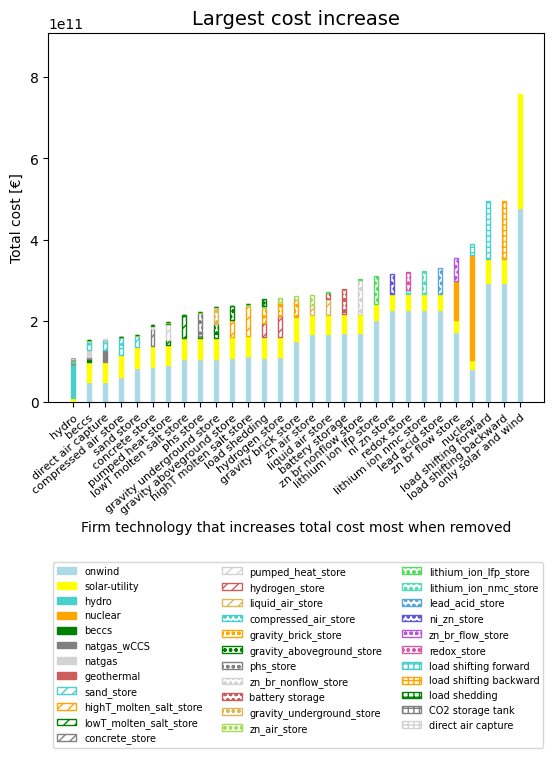

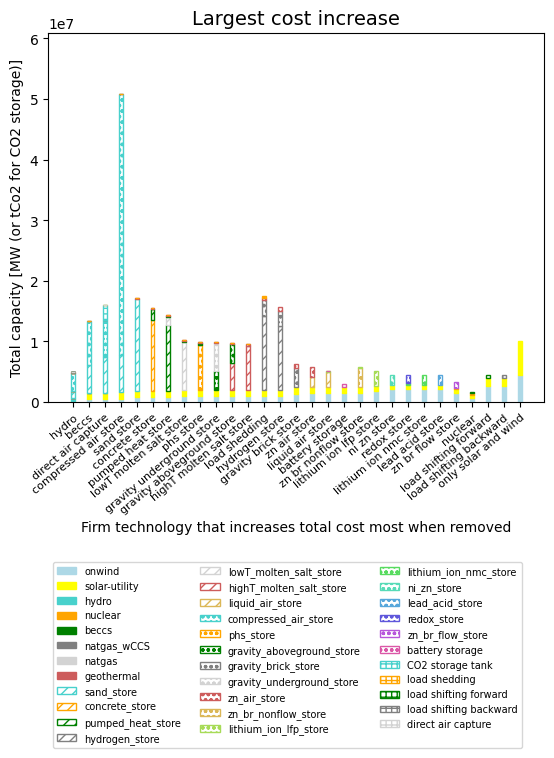

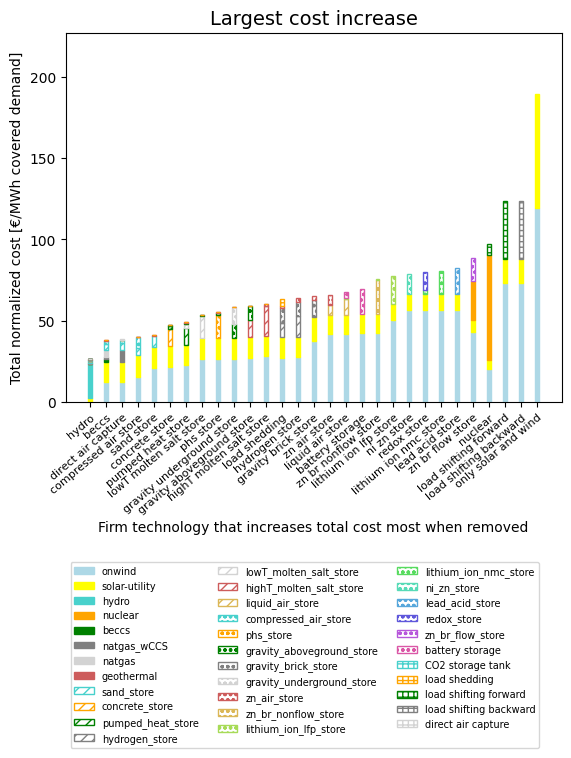

In [3]:
# Results directory
out_suff = '_all_stores_most'
results_dir = 'output_data/all_firm_case'+out_suff
removal_plot = True
results_dir += '/plotting/' if removal_plot == True else '/'

# Get generators
generators = ['onwind', 'solar-utility', 'natgas', 'natgas_wCCS', 'nuclear', 'beccs', 'hydro', 'geothermal']
storage_unconstrained = ['hydrogen_store', 'concrete_store', 'highT_molten_salt_store', 'liquid_air_store', 'lowT_molten_salt_store', 'pumped_heat_store', 'sand_store']
storage_constrained = ['battery storage', 'lead_acid_store', 'lithium_ion_lfp_store', 'lithium_ion_nmc_store', 'ni_zn_store', 'redox_store', 'zn_air_store', 'zn_br_flow_store', 'zn_br_nonflow_store', 'compressed_air_store', 'gravity_brick_store', 'gravity_aboveground_store', 'gravity_underground_store', 'phs_store']
demand_handling = ['load shedding', 'load shifting backward', 'load shifting forward', 'CO2 storage tank', 'direct air capture']

technologies = {'generators': generators, 'storage_unconstrained': storage_unconstrained, 'storage_constrained': storage_constrained, 'demand_handling': demand_handling}

# Get color map
color_dict = get_colors()

# Plot
costs = plot_results(results_dir, color_dict, 'cost', technologies, outfile_suffix=out_suff, rm_plot=removal_plot)
capacities = plot_results(results_dir, color_dict, 'capacity', technologies, outfile_suffix=out_suff, rm_plot=removal_plot)
if removal_plot == True:
    total_demand = abs(get_demand(results_dir, 'all_firm_all.pickle'))
else:
    total_demand = abs(get_demand(results_dir, 'all_firm_1p0.pickle'))

system_costs = [{} for i in range(len(costs))]
for i,case in enumerate(costs):
    for comp in case:
        system_costs[i][comp] = case[comp]/total_demand

plot_results(results_dir, color_dict, 'normalized_cost', technologies, outfile_suffix=out_suff, pass_results=['system_cost [€/MWh]', system_costs], rm_plot=removal_plot)